#### This notebook contains the full code for processing 21cm line from SALSA telescope: https://liv.oso.chalmers.se/salsa/welcome. This code contains a combination of elements written by myself, Ana Pilar Ravanne, groupmate Cameron Cackett, and supervisor Jeffrey Grube.

### Import packages and files:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fileSM = "data/salsamax.txt"
fileSP = "data/salsapeak.txt"

with open(fileSM, "w") as f1, open(fileSP, "w") as f2:
    pass

### Plotting Galactic longitudes used in SALSA observations:

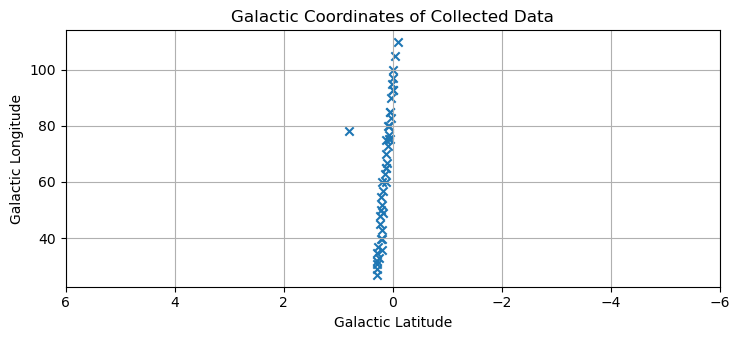

In [2]:
#Script to plot galactic coordinates of collected data from SALSA telescope.

directory = 'C:\\Documents\\Radio Telescope\\spectra'
#Name of main folder.

files = os.listdir(directory)
#Create a list of files.

xCoords = []
yCoords = []
#Empty list of coordinates.

for f in files:
    spectrum = os.path.join(directory, f)
    #Attach directory to file names
    spectrumOpen = open(spectrum)
    #Open files
    content = spectrumOpen.readlines()
    #Read files
    yCoords.append(float(content[4].replace('# GLON=','').strip()))
    xCoords.append(float(content[5].replace('# GLAT=','').strip()))
    #Takes number from each coordinate line and adds to list.
    spectrumOpen.close()

plt.scatter(xCoords, yCoords, marker="x")
plt.title('Galactic Coordinates of Collected Data')
plt.ylabel('Galactic Longitude')
plt.xlabel('Galactic Latitude')
plt.xlim(6,-6)
plt.grid()
plt.show()
#Plots the galactic coordinates of the given data.

### Plotting SALSA spectra with max (blue line) and peak (orange) velocities 

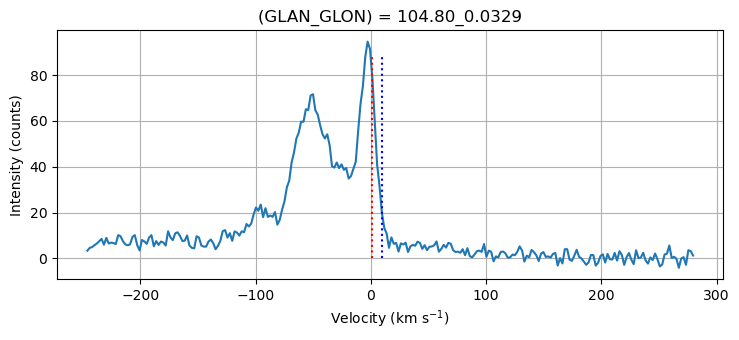

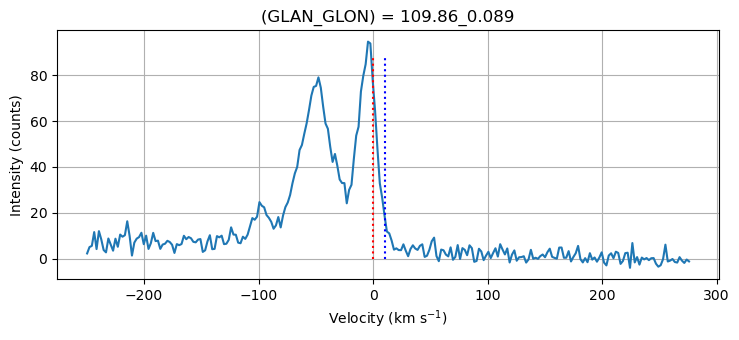

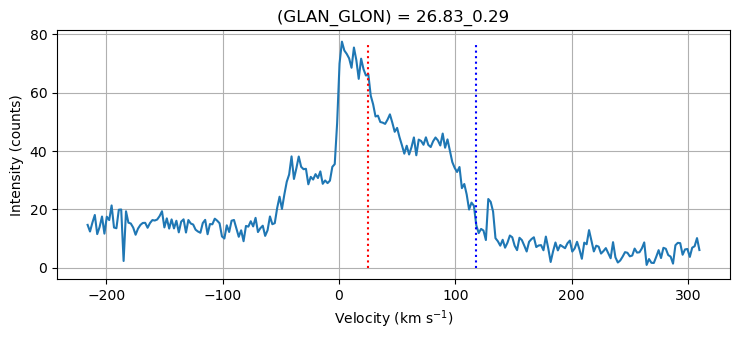

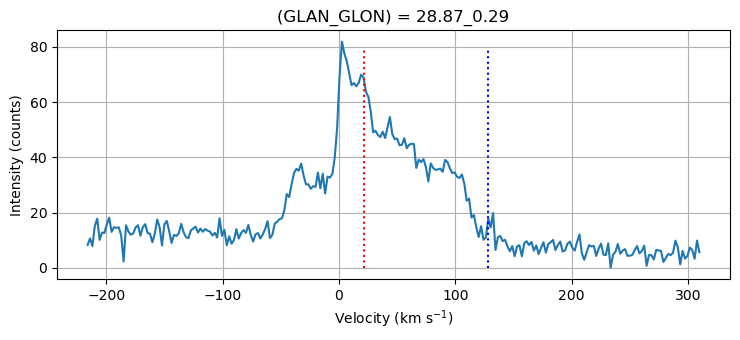

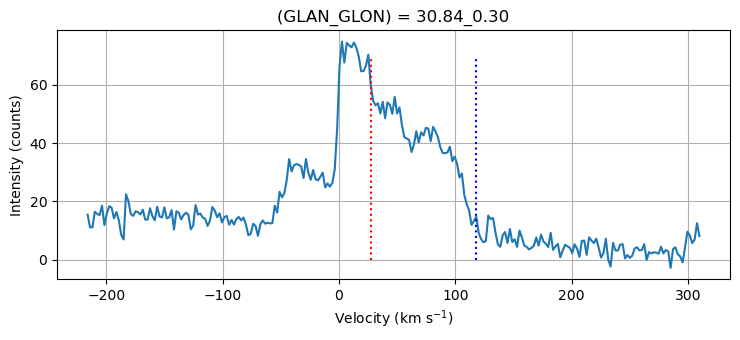

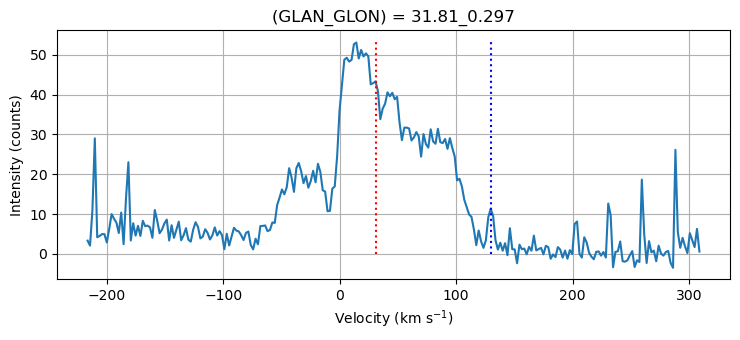

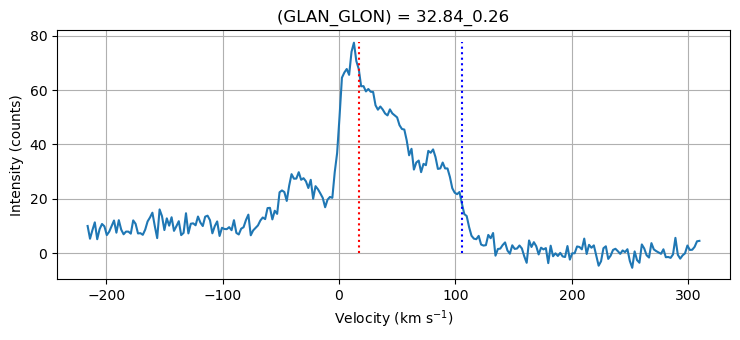

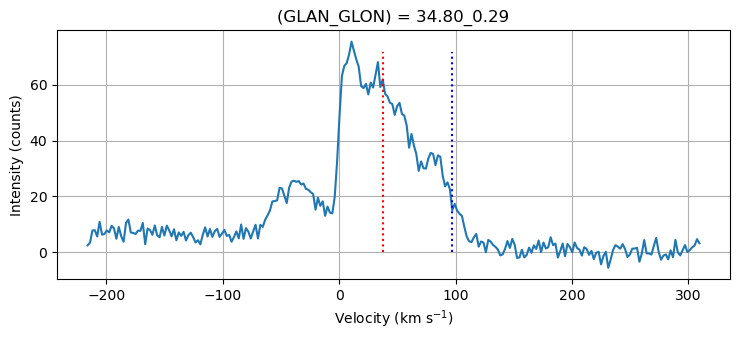

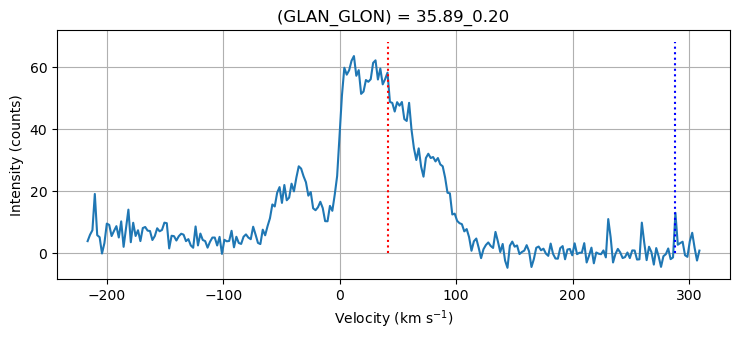

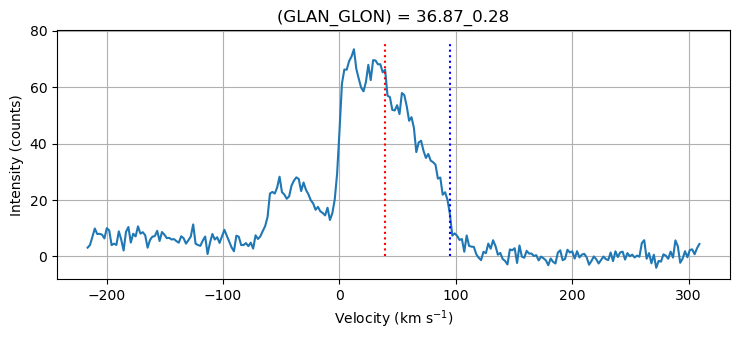

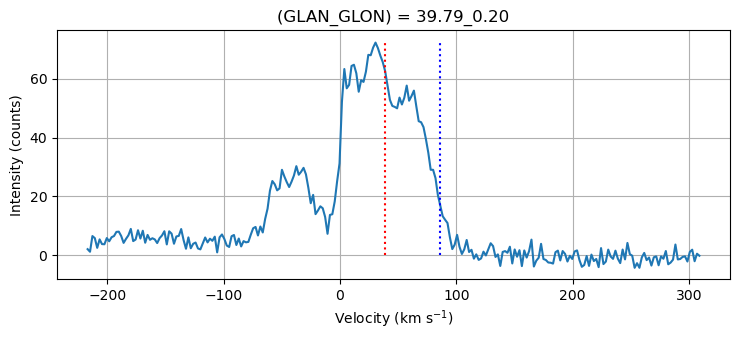

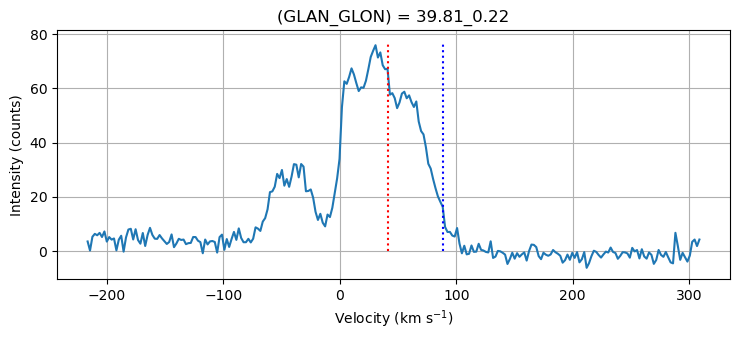

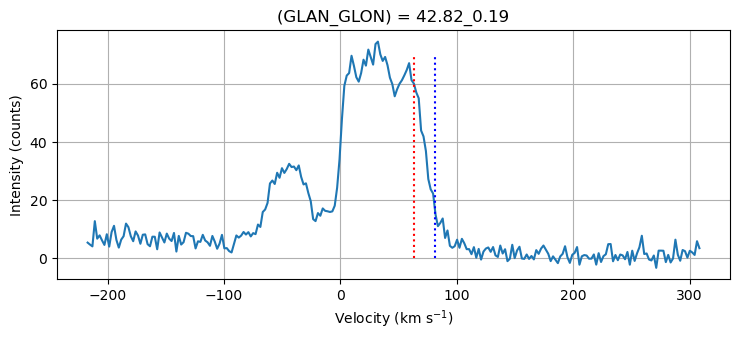

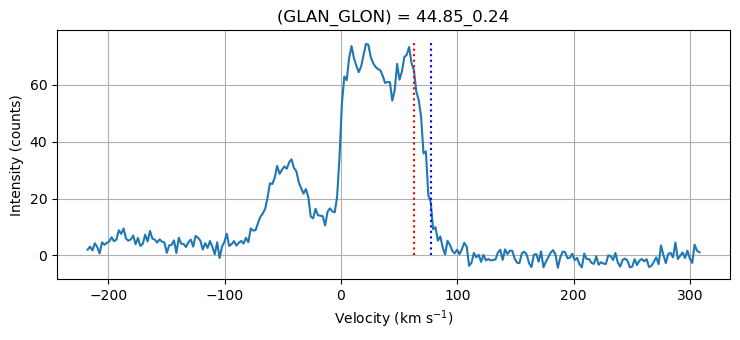

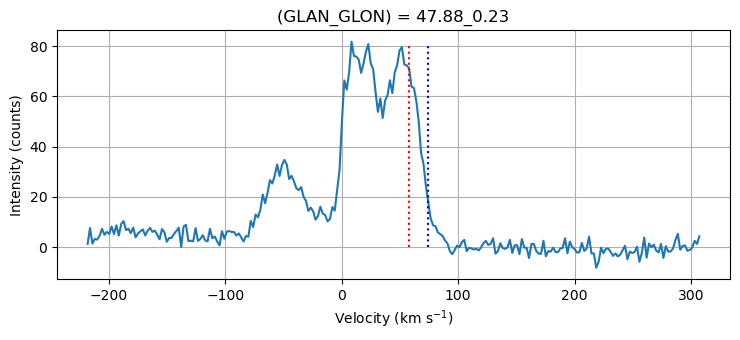

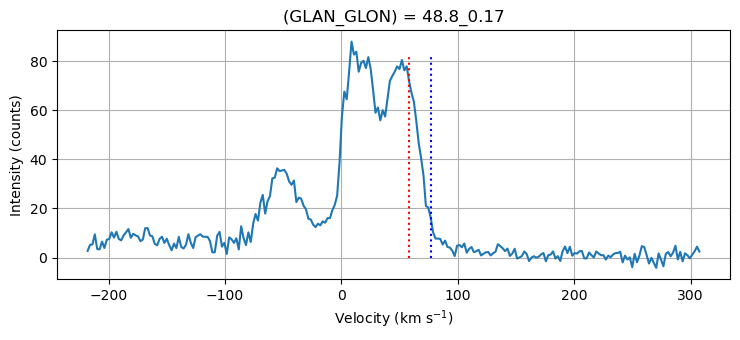

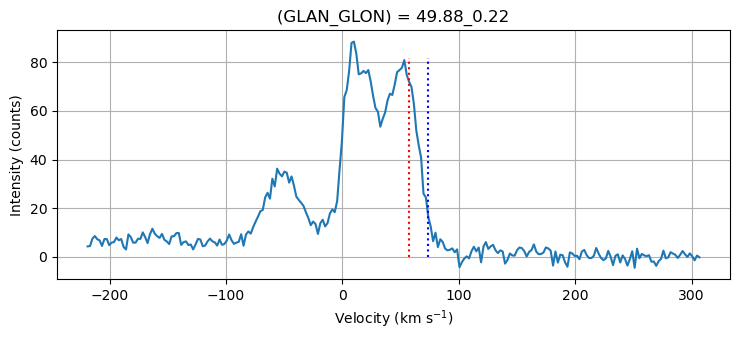

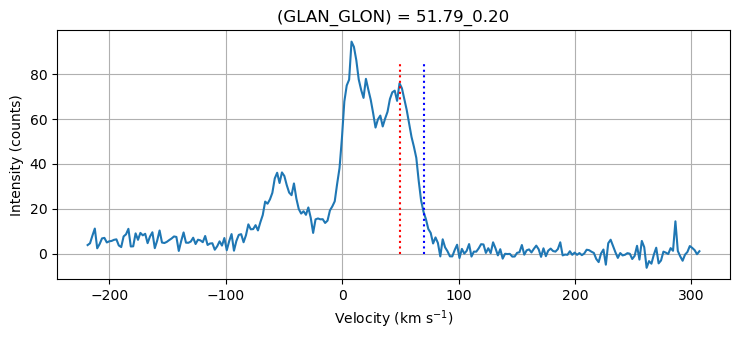

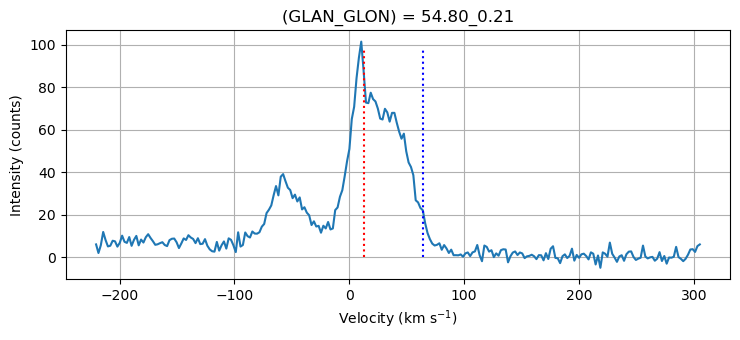

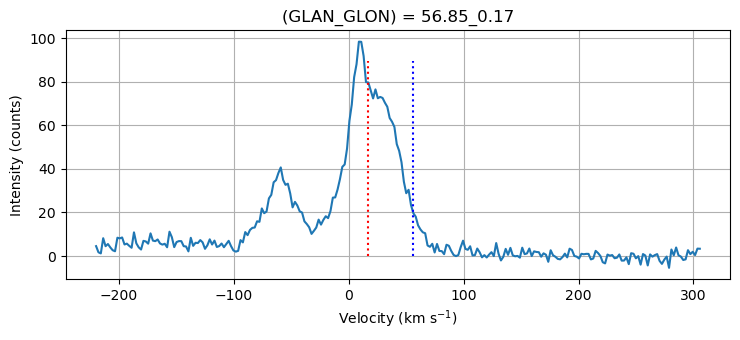

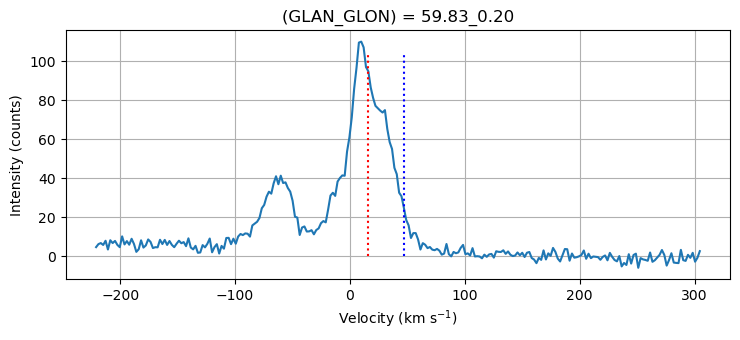

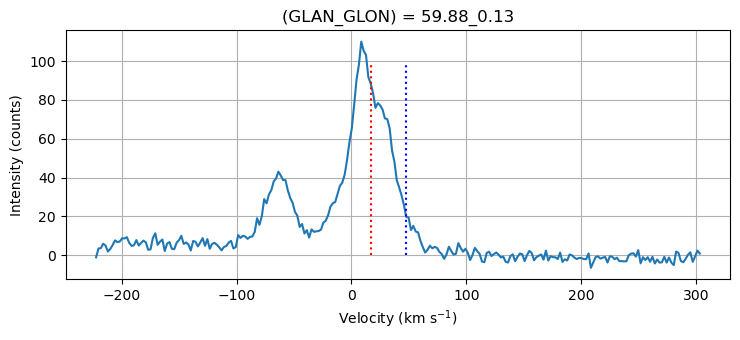

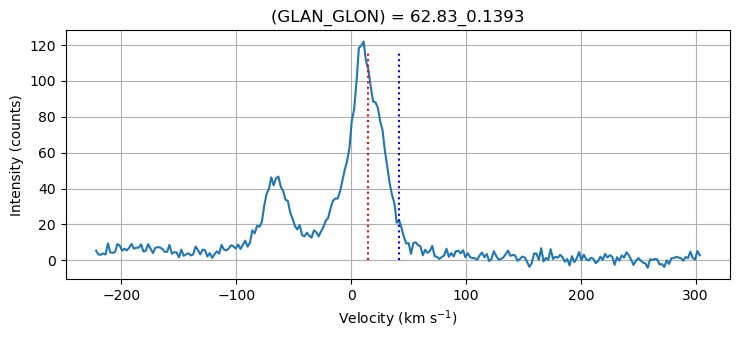

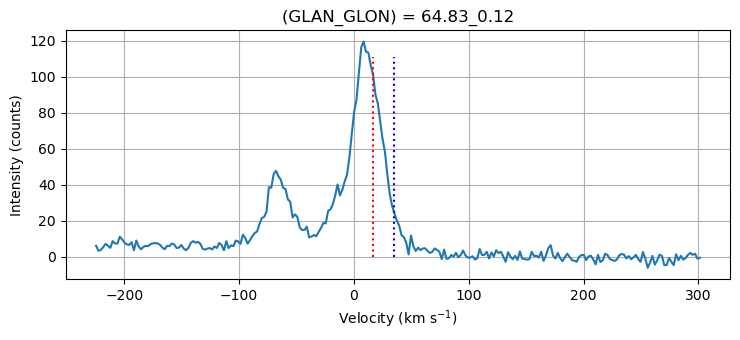

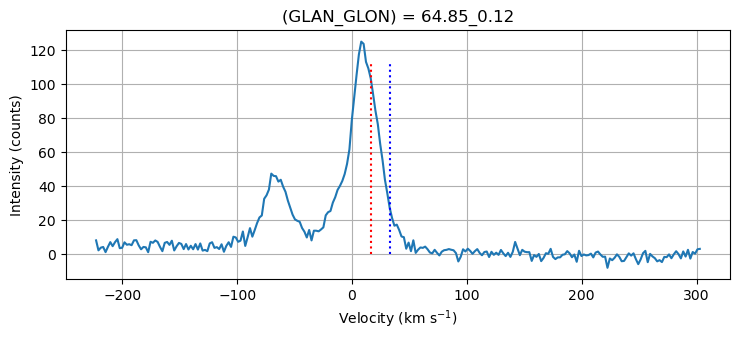

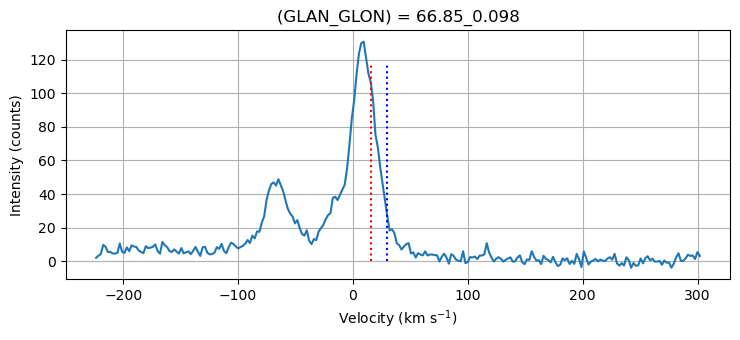

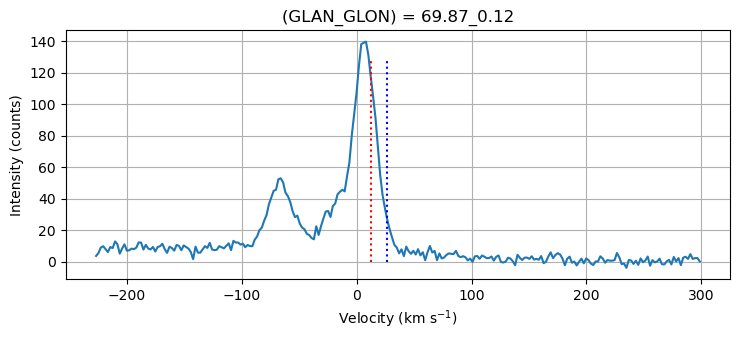

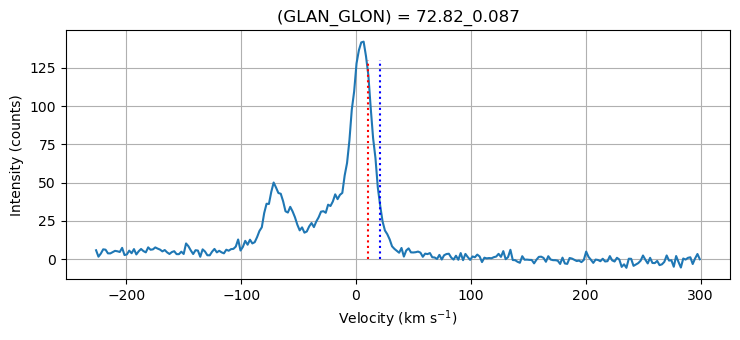

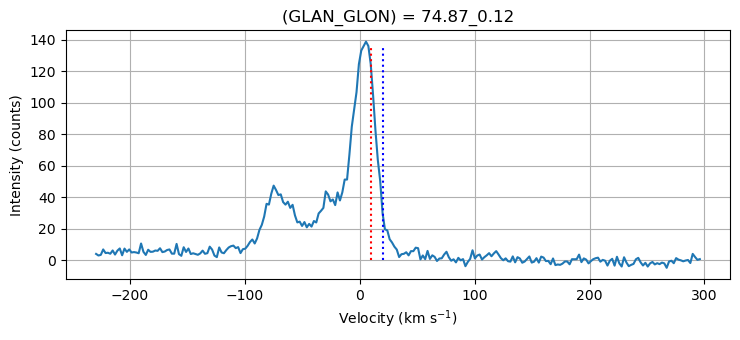

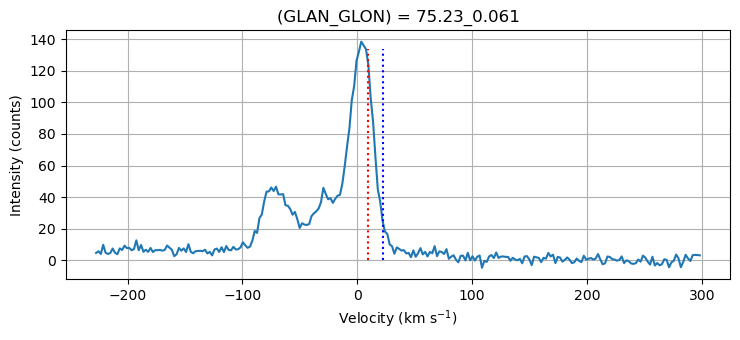

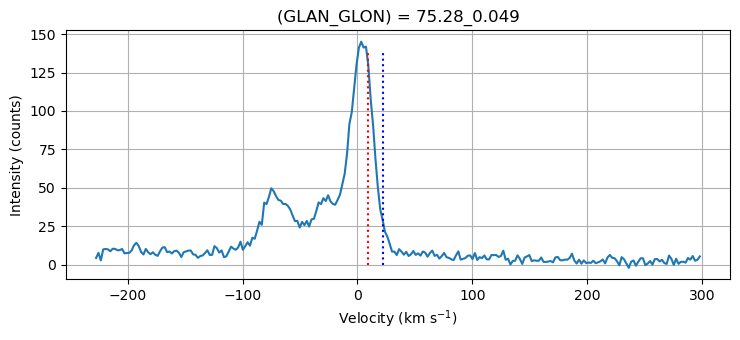

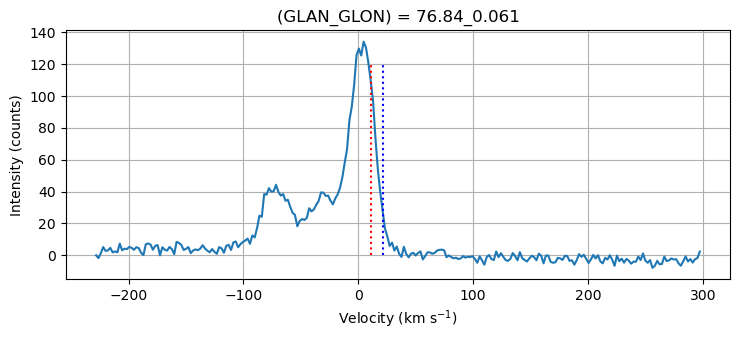

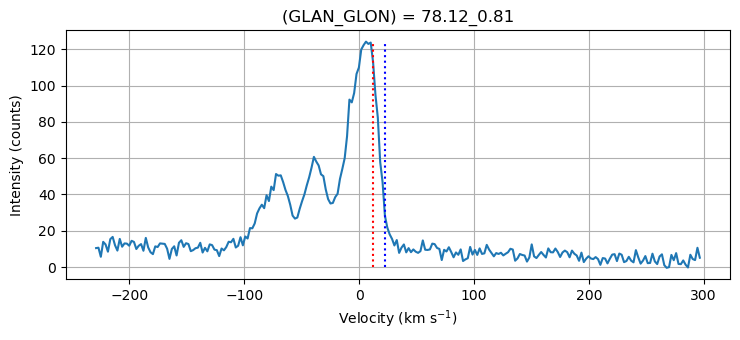

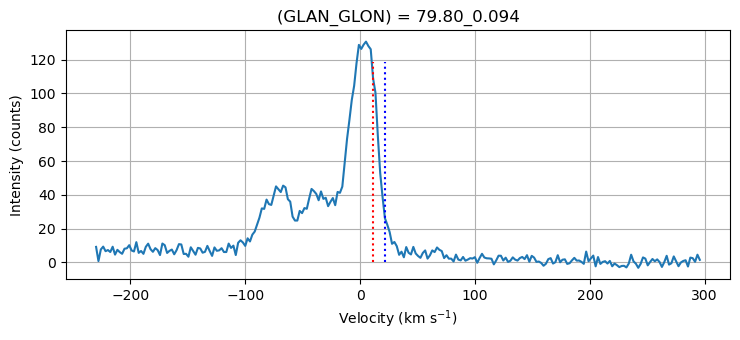

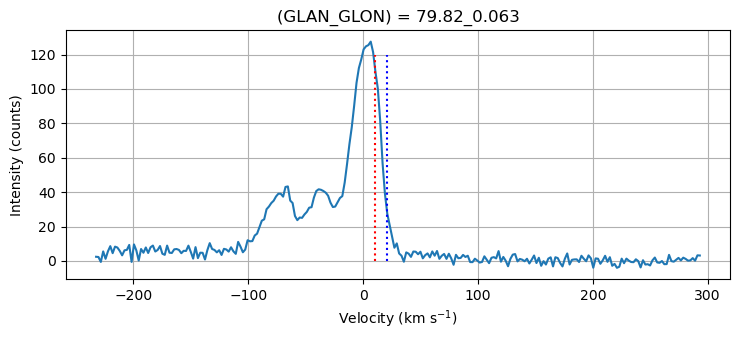

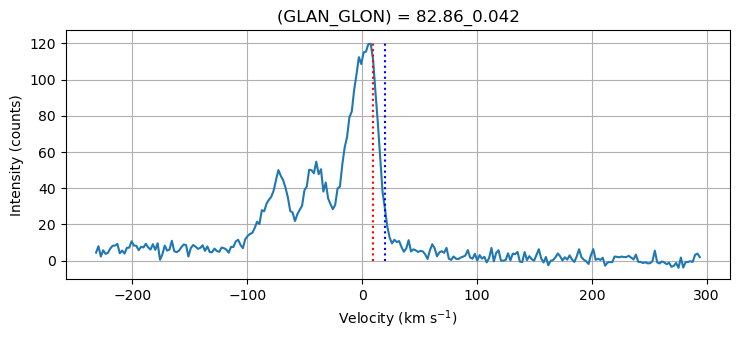

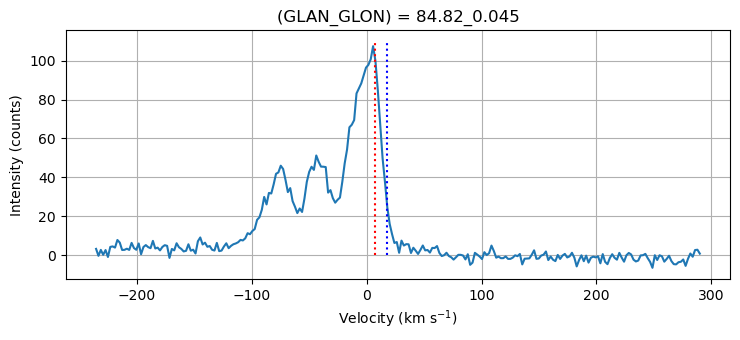

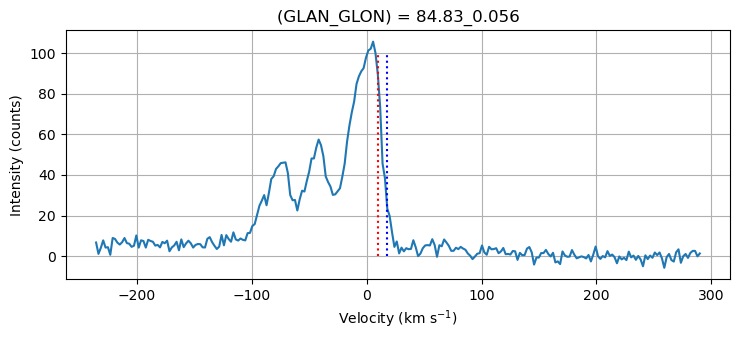

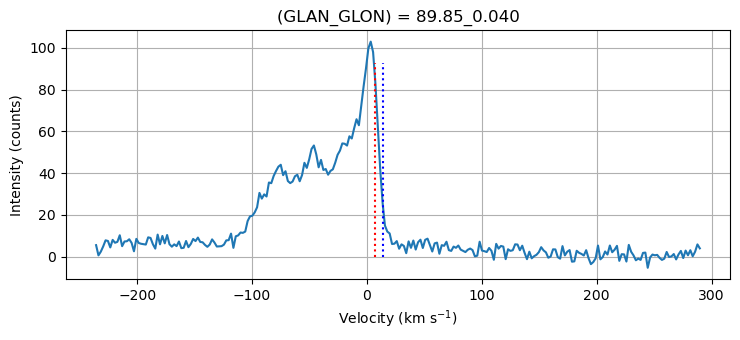

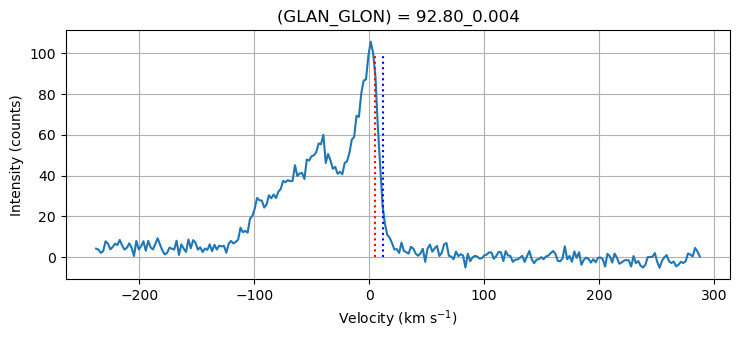

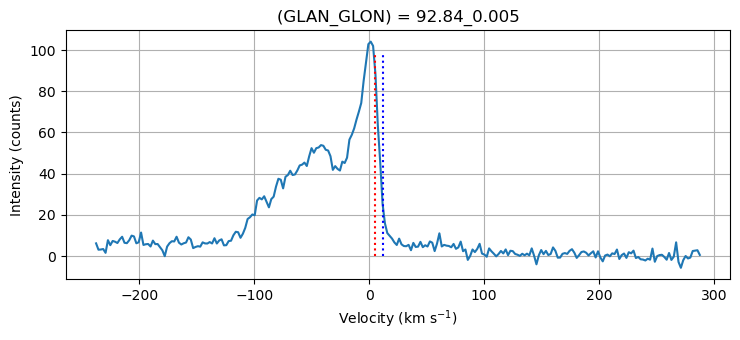

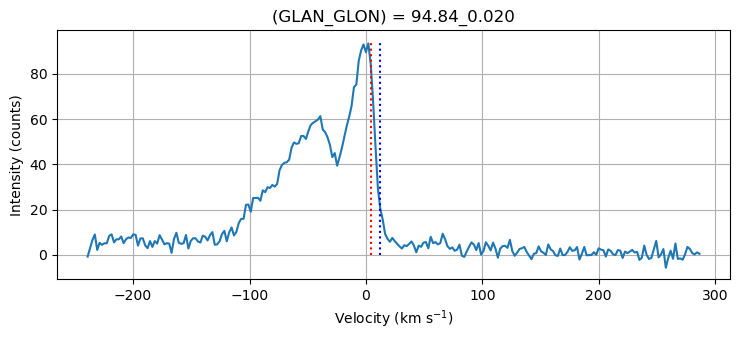

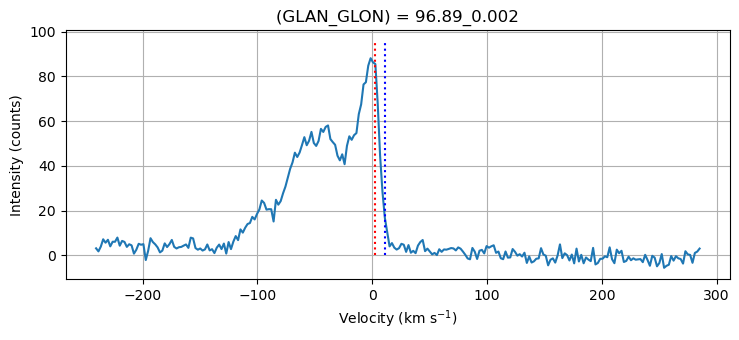

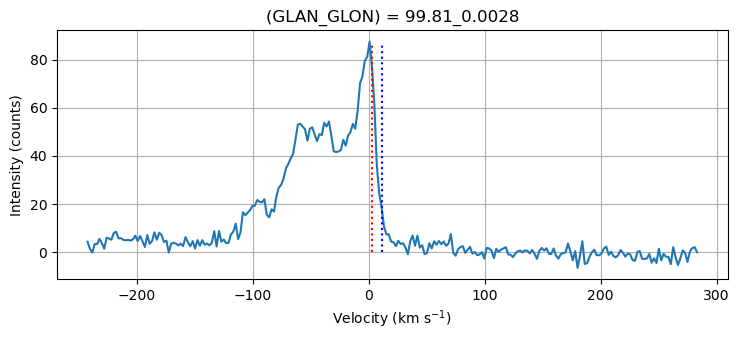

In [3]:
def plot_spectrum(filename, peak_threshold=0.2):
   
    # Load spectrum data from file
    vel, P = np.loadtxt('data/spectra/{}'.format(filename), skiprows=8, unpack=True)

    # Find the peak velocities and intensities
    max_intensity = np.max(P)
    peak_indices = np.where(P >= 0.8 * max_intensity)[0]
    peak_velocities = vel[peak_indices]
    peak_intensities = P[peak_indices]

    # Find the velocity of the peak with the greatest x value
    peak_index = np.argmax(peak_velocities)
    peak_velocity = peak_velocities[peak_index]
    peak_intensity = peak_intensities[peak_index]

    # Find the velocity corresponding to the specified threshold intensity
    threshold_intensity = peak_threshold * peak_intensity
    threshold_index = np.argmin(abs(P[:peak_indices[peak_index]] - threshold_intensity))
    threshold_velocity = vel[threshold_index]

    # Plot the data and vertical lines
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(r"Velocity (km s$^{-1}$)")
    ax1.set_ylabel(r"Intensity (counts)")
    ax1.ticklabel_format(axis='x', style='plain')
    ax1.plot(vel, P, linestyle='-')

    mlinex = [peak_velocity, peak_velocity] 
    mliney = [0, peak_intensity + 10]
    plinex = [threshold_velocity, threshold_velocity] 
    pliney = [0, peak_intensity + 10]
    ax1.plot(mlinex, mliney, linestyle='dotted', color='red') 
    ax1.plot(plinex, pliney, linestyle='dotted', color='blue')

    GLON_GLAN = filename[:-4].split('_')
    GLON_file = float(GLON_GLAN[0])

    with open(fileSM, "a") as f1, open(fileSP, "a") as f2:
        f1.write('{} {}\n'.format(GLON_file, threshold_velocity))
        f2.write('{} {}\n'.format(GLON_file, peak_velocity))

    plt.tight_layout()
    plt.title('(GLAN_GLON) = ' + filename[:-4])
    plt.grid()
    plt.savefig('plots/{}.png'.format(filename[:-4]))
    plt.show()
    plt.close()

#Define the directory path where the files are located
directory = 'data/spectra'

#Get a list of all the files in the directory
files = os.listdir(directory)

# Create the 'plots' directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

for f in files:
    if not f.endswith('.ipynb_checkpoints'):
        file_path = os.path.join(directory, f)
        plot_spectrum(f, 0.25)

### Plotting the Milky Way rotation curve:

In [4]:
# make figure interactive
%matplotlib ipympl
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#### Importing SALSA data and models:

In [5]:
## model from (McGaugh, 2018, RNAAS, 2, 156)
Rm,Vbm,Vgm,Vkm,Vdm,Vm,Vcm = np.loadtxt("data/McGaugh_model.txt", skiprows=3, unpack = True)
## data from (McClure-Griffiths & Dickey, 2007, ApJ, 671, 427)
Rc,Vc = np.loadtxt("data/McClure07.txt", skiprows=3, unpack = True)
## our SALSA data (measured at edge of largest velocity)
glonM,V0M= np.loadtxt("data/salsamax.txt", unpack = True)
## our SALSA data (measured at highest peak in velocity)
glonP,V0P = np.loadtxt("data/salsapeak.txt", unpack = True)

#### Solar values:

In [6]:
vsun = 233  # km/s
rsun = 8.12  # kpc
##vsun = 233 # km/s (McGaugh)
##rsun = 8.12 # kpc (McGaugh)

vsinl = vsun * np.sin( glonM * np.pi / 180.)
rsinl = rsun * np.sin( glonM * np.pi / 180.)
rcosl = rsun * np.cos( glonM * np.pi / 180.)

#### Estimate reading error and calculate rotational velocities

In [7]:
vread = 5 # km/s (error from reading by eye)

vrotM = V0M + vsinl  # edge of largest velocity
vrotP = V0P + vsinl  # highest peak in velocity

#### Plot rotation curve!

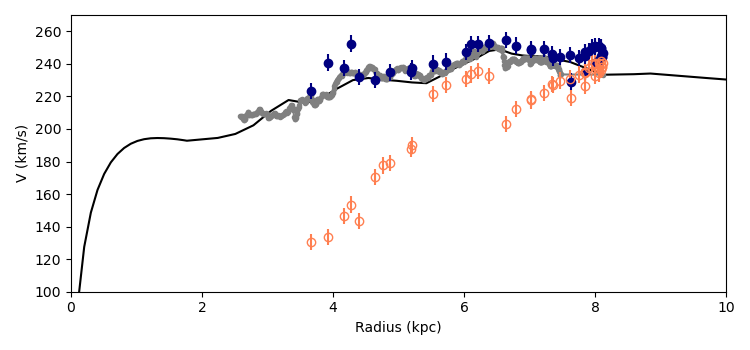

In [8]:
fig, ax1 = plt.subplots()
ax1.set_xlabel(r"Radius (kpc)")
ax1.set_ylabel(r"V (km/s)")
ax1.set_xlim(0, 10)
ax1.set_ylim(100, 270)
ax1.ticklabel_format(axis='x', style='plain')
ax1.plot(Rm,Vm, linestyle='-',color='k') ## total McGaugh model
ax1.plot(Rc,Vc, marker='o', markersize=3, color='grey') ## McClure data
ax1.errorbar(rsinl,vrotM, yerr=vread, fmt='o', color='navy')
ax1.errorbar(rsinl,vrotP, yerr=vread, fmt='o', fillstyle='none', color='coral')
plt.tight_layout()

### Mapping the Milky Way:

#### Equations for galaxy arms:

In [9]:
# gas cloud distance to galactic center
r = (rsun * vsun * np.sin(glonM))/(vsun * np.sin(glonM) + V0M) 

# distance between sun and gas clouds
d_pos = np.sqrt(r**2+(rsun*np.sin(glonM)**2))+rsun*np.cos(glonM)

d_neg = -np.sqrt(r**2+(rsun*np.sin(glonM)**2))+rsun*np.cos(glonM)

#### Converting to polar coordinates:

In [10]:
x = d_pos*np.cos(glonM-90)
y = d_pos*np.sin(glonM-90)

#### Plot galaxy!

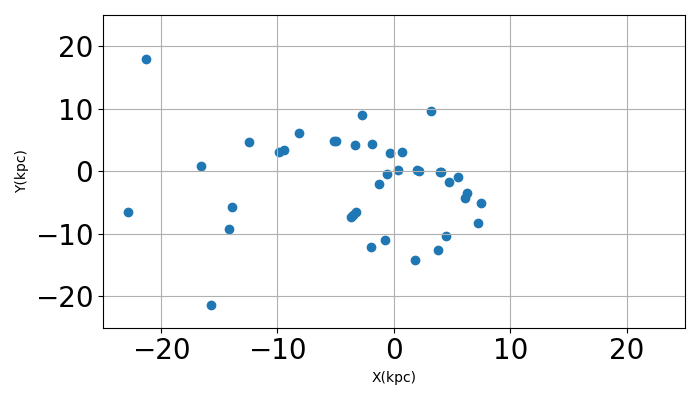

In [11]:
plt.figure(figsize = (7,4))
plt.scatter(x,y)
plt.xlabel("X(kpc)")
plt.ylabel("Y(kpc)")
plt.ylim(-25,25)
plt.xlim(-25,25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
axes = plt.gca()
axes.xaxis.label.set_size(10)
axes.yaxis.label.set_size(10)
plt.grid()
plt.savefig('Milky Way Arm.png')